## SETUP

### Setting CLIP model

In [1]:
%pip install git+https://github.com/openai/CLIP.git

  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git 'C:\Users\DELL\AppData\Local\Temp\pip-req-build-h4qz6pgq'



  Cloning https://github.com/openai/CLIP.git to c:\users\dell\appdata\local\temp\pip-req-build-h4qz6pgq
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


## PIPELINE

In [1]:
import os
import numpy as np

from tqdm import tqdm
from PIL import Image

import torch
import clip


IMAGE_KEYFRAME_PATH = r"D:\CLB-AI\AI Challenge 2023\Data\Keyframes"
VISUAL_FEATURES_PATH = r"D:\CLB-AI\AI Challenge 2023\Data\clip-features"

### Text Embedding

In [2]:
class TextEmbedding():
  def __init__(self):
    self.device = "cuda" if torch.cuda.is_available() else "cpu"
    self.model, _ = clip.load("ViT-B/32", device=self.device)

  def __call__(self, text: str) -> np.ndarray:
    text_inputs = clip.tokenize([text]).to(self.device)
    with torch.no_grad():
        text_feature = self.model.encode_text(text_inputs)[0]

    return text_feature.detach().cpu().numpy()


# ==================================
text = "A car is parked on the road"
text_embedd = TextEmbedding()
text_feat_arr = text_embedd(text)
print(type(text_feat_arr))
print(text_feat_arr.shape)

<class 'numpy.ndarray'>
(512,)


In [3]:
class ImageEmbedding():
    def __init__(self):
        self.device = "cpu"
        self.model, self.preprocess = clip.load("ViT-B/32", device=self.device)

    def __call__(self, image_path: str) -> np.ndarray:
        image = Image.open(image_path).convert("RGB")
        image_input = self.preprocess(image).unsqueeze(0).to(self.device)

        with torch.no_grad():
            image_feature = self.model.encode_image(image_input)[0]

        return image_feature.detach().cpu().numpy()

# Example usage
image_path = r"D:\CLB-AI\AI Challenge 2023\Data\Keyframes\Keyframes_L01\keyframes\L01_V001\0221.jpg"
image_embedder = ImageEmbedding()
image_feat_arr = image_embedder(image_path)
print(type(image_feat_arr))
print(image_feat_arr.shape)

<class 'numpy.ndarray'>
(512,)


### Indexing

In [4]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from natsort import natsorted
from typing import List, Tuple

def indexing_methods(features_path: str) -> pd.DataFrame:
    data = {'video_name': [], 'frame_index': [], 'features_vector': [], 'features_dimension': []}

    npy_files = natsorted([file for file in os.listdir(features_path) if file.endswith(".npy")])

    for feat_npy in tqdm(npy_files):
        video_name = feat_npy.split('.')[0]
        feats_arr = np.load(os.path.join(features_path, feat_npy))

        # Lặp qua từng dòng trong feats_arr, mỗi dòng là một frame
        for idx, feat in enumerate(feats_arr):
            data['video_name'].append(video_name)
            data['frame_index'].append(idx)
            data['features_vector'].append(feat)
            data['features_dimension'].append(feat.shape)

    df = pd.DataFrame(data)
    return df

FEATURES_PATH = r"D:\CLB-AI\AI Challenge 2023\Data\clip-features-vit-b32"
visual_features_df = indexing_methods(FEATURES_PATH)

visual_features_df.head()  # Hiển thị năm dòng đầu của DataFrame

100%|██████████| 299/299 [00:05<00:00, 52.11it/s]


,video_name,frame_index,features_vector,features_dimension
0,L01_V001,0,"[0.03004, 0.03555, 0.012825, 0.02281, 0.000226...","(512,)"
1,L01_V001,1,"[0.00273, -0.03497, 0.0119, -0.00872, 0.0417, ...","(512,)"
2,L01_V001,2,"[-0.004097, -0.02765, -0.012405, 0.0237, 0.020...","(512,)"
3,L01_V001,3,"[-0.01027, 0.01116, -0.03041, -0.0002214, 0.01...","(512,)"
4,L01_V001,4,"[0.00534, -0.01791, -0.02013, 0.00421, 0.04343...","(512,)"


### Search engine

In [5]:
def search_engine(query_arr: np.array,
                  db: list,
                  topk:int=10,
                  measure_method: str="cosine_similarity") -> List[dict]:

    '''Duyệt tuyến tính và tính độ tương đồng giữa 2 vector'''
    measure = []
    for ins_id, instance in enumerate(db):
        video_name, idx, feat_vec, feat_dim = instance

        distance = 0
        if measure_method == "cosine_similarity":
            dot_product = query_arr @ feat_vec
            query_norm = np.linalg.norm(query_arr)
            feat_norm = np.linalg.norm(feat_vec)
            cosine_similarity = dot_product / (query_norm * feat_norm)
            distance = 1 - cosine_similarity
        else:
            distance = np.linalg.norm(query_arr - feat_vec, ord=1)

        measure.append((ins_id, distance))

    '''Sắp xếp kết quả'''
    measure = sorted(measure, key=lambda x:x[1])

    '''Trả về top K kết quả'''
    search_result = []
    for instance in measure[:topk]:
        ins_id, distance = instance
        video_name, idx = db[ins_id][0], db[ins_id][1]

        search_result.append({"video_name": video_name,
                              "keyframe_id": idx+1,
                              "score": distance})

    # Đảm bảo trả về đúng topk kết quả
    while len(search_result) < topk and len(measure) > len(search_result):
        ins_id, distance = measure[len(search_result)]
        video_name, idx = db[ins_id][0], db[ins_id][1]
        search_result.append({"video_name": video_name,
                              "keyframe_id": idx,
                              "score": distance})

    return search_result

In [6]:
# Example query image
image_path = r"D:\CLB-AI\AI Challenge 2023\Data\Keyframes\Keyframes_L01\keyframes\L01_V001\0221.jpg"
query_img_feature = image_embedder(image_path)
# Search for similar frames in the visual_features_df DataFrame
search_results = search_engine(query_img_feature, visual_features_df.values)

# Print the search results
for result in search_results:
    print(result)

{'video_name': 'L01_V001', 'keyframe_id': 221, 'score': -0.00018584728240966797}
{'video_name': 'L01_V001', 'keyframe_id': 220, 'score': 0.18435168266296387}
{'video_name': 'L06_V020', 'keyframe_id': 82, 'score': 0.24905610084533691}
{'video_name': 'L04_V026', 'keyframe_id': 195, 'score': 0.2534298300743103}
{'video_name': 'L02_V001', 'keyframe_id': 128, 'score': 0.2782095670700073}
{'video_name': 'L09_V021', 'keyframe_id': 237, 'score': 0.2830560803413391}
{'video_name': 'L01_V001', 'keyframe_id': 222, 'score': 0.28324979543685913}
{'video_name': 'L02_V029', 'keyframe_id': 170, 'score': 0.28549647331237793}
{'video_name': 'L02_V018', 'keyframe_id': 209, 'score': 0.28685230016708374}
{'video_name': 'L07_V007', 'keyframe_id': 132, 'score': 0.29062187671661377}


### Visualize

In [7]:
import os
from typing import List
from PIL import Image

def read_image(results: List[dict]):
    images = []
    data = []
    IMAGE_KEYFRAME_PATH = r"D:\CLB-AI\AI Challenge 2023\Data\Keyframes"  # Đường dẫn đến thư mục chứa keyframes

    for res in results:
        data.append(res)
        video_name = res["video_name"]
        keyframe_id = res["keyframe_id"]
        temp = video_name.split('_')
        video_folder = os.path.join(IMAGE_KEYFRAME_PATH, 'Keyframes_' + temp[0], 'keyframes', video_name)

        if os.path.exists(video_folder):
            image_files = sorted(os.listdir(video_folder))

            if keyframe_id < len(image_files):
                image_file = image_files[keyframe_id]
                image_path = os.path.join(video_folder, image_file)
                image = Image.open(image_path)
                images.append(image)
            else:
                print(f"Keyframe id {keyframe_id} is out of range for video {video_name}.")

    return (images, data)

def visualize(imgs,data) -> None:
    rows = len(imgs) // 5
    if not rows:
        rows += 1
    cols = len(imgs) // rows
    if rows * cols < len(imgs):
        rows += 1
    w, h = imgs[0].size

    for i, img in enumerate(imgs):
        print("Picture-result number {}: ".format(i+1), data[i]["video_name"], data[i]["keyframe_id"])
        temp = img.resize((320, 180))
        grid = Image.new('RGB', size=(320, 180))
        grid.paste(temp)
        display(grid)

## DEMO

Picture-result number 1:  L05_V013 199


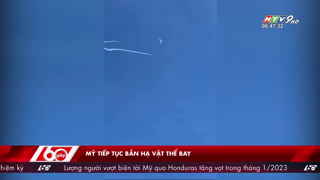

Picture-result number 2:  L05_V022 208


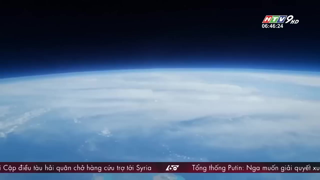

Picture-result number 3:  L02_V027 128


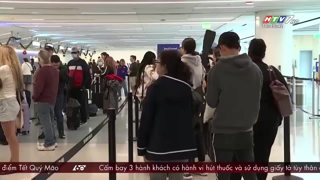

Picture-result number 4:  L05_V005 279


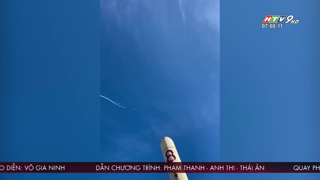

Picture-result number 5:  L10_V030 100


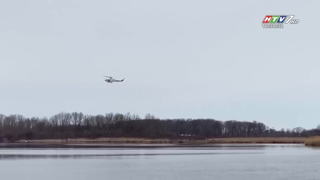

Picture-result number 6:  L02_V009 73


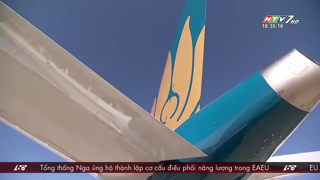

Picture-result number 7:  L04_V031 106


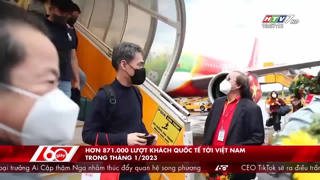

Picture-result number 8:  L08_V021 23


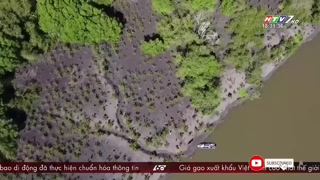

Picture-result number 9:  L05_V005 280


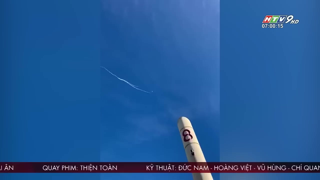

Picture-result number 10:  L05_V005 281


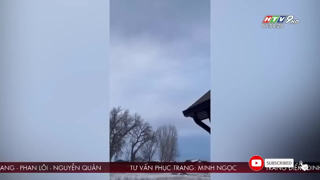

In [8]:
from IPython.display import clear_output

# Thực hiện xóa output hiện tại
clear_output()

# Thay đổi các giá trị dựa trên tùy chọn của người dùng
text_query = "An airplane flying" #@param {type:"string"}
topk = 10 #@param {type:"slider", min:0, max:25, step:1}
measure_method = 'l1_norm' #@param ["l1_norm", "cosine_similarity"]

# Tạo vector biểu diễn cho câu truy vấn văn bản
text_feat_arr = text_embedd(text_query)

# Chuyển DataFrame thành danh sách tuples
visual_features_db = visual_features_df.to_records(index=False).tolist()

# Thực hiện tìm kiếm và hiển thị kết quả
search_result = search_engine(text_feat_arr, visual_features_db, topk, measure_method)
(images, data) = read_image(search_result)
visualize(images, data)